In [128]:
from sklearn.preprocessing import RobustScaler #robust normlization for outliers
import sklearn.metrics as metrics #metrics librry
import seaborn as sns # for intractve graphs
from sklearn.ensemble import RandomForestClassifier #Random Forest
import matplotlib.pyplot as plt #for visualization
from xgboost.sklearn import XGBClassifier #XGBoost
from sklearn.metrics import classification_report
from xgboost import plot_importance #feature rimportance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dense, BatchNormalization #layers of autoencoder
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping #callbacks
from tensorflow.keras import regularizers #regularization
from sklearn.ensemble import IsolationForest #Isolation Forest
from sklearn.mixture import GaussianMixture #Gaussian Mixture
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [129]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Vou aplicá-lo usando a base de dados de fraude de crédito disponível no kaggle e comparar com técnicas utilizando aprendizado supervisionado. Com relação à base de dados, ela está disponível para download nesse link. Contém como input as seguintes variáveis:

- **Time**: Número de segundos decorridos entre a transação atual e a primeira transação no conjunto de dados;
Amount: Valor da transação.
- **V1-V28**: inputs codificados via PCA como forma de manter sigilo nos dados do cliente.

Como output, a base tem 0.17% dos dados (492 de 284.000) rotulados como fraude, o que a torna muito desbalanceada. Devido a isso, não podemos usar a acurácia para avaliar a performance do algoritmo, já que se marcássemos todos os dados como normais (não frades), teríamos uma acurácia de 99,83%, o que não vem ao caso para nossos propósitos. Métricas mais utilizadas nesse caso seria:

In [4]:
dataframe = pd.read_csv("creditcard.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<h3> Robust Normalization </h3>

The Robust normalization is a scale features using statistics that are robust to outliers and in our model perform better than Standar Scaler. Let's apply Robust normalization and shuffle the data points.

In [5]:
RS=RobustScaler()
dataframe['Amount'] = RS.fit_transform(dataframe['Amount'].values.reshape(-1, 1))
dataframe['Time'] = RS.fit_transform(dataframe['Time'].values.reshape(-1, 1))
df = dataframe.sample(frac=1, random_state = 42)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,-0.507372,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,4.781527,1
49906,-0.474994,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,6.960386,0
29474,-0.578108,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0.125760,0
276481,0.968421,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.286453,0
278846,0.984281,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.294977,0


<h3> Undersampling e Oversampling</h3>

Since the dataset is extremely unbalanced (492 frudes and 284315 normal data points), we need to undersample the normal data points. With the procedure below, we will get a 9:1 ratio dataset between normal data points and fraud.

Normal 99.83 % of the dataset
Fraud 0.17 % of the dataset


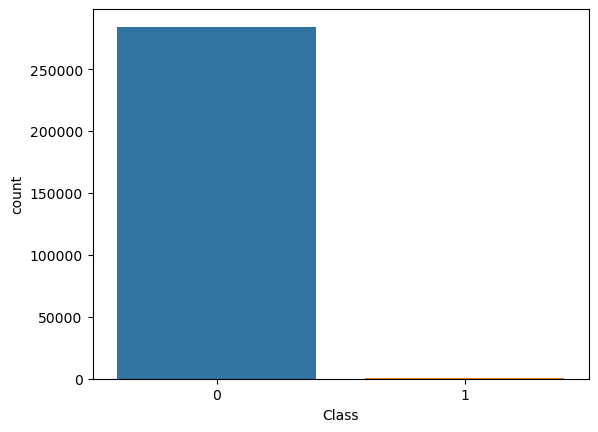

In [12]:
print('Normal', round(
        df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Fraud', round(
        df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')
sns.countplot(x=df["Class"]);

In [21]:
# Perform stratified train-test split
X = df.drop(columns = "Class")
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Apply Undersampling. Fraude represent 10% of base now

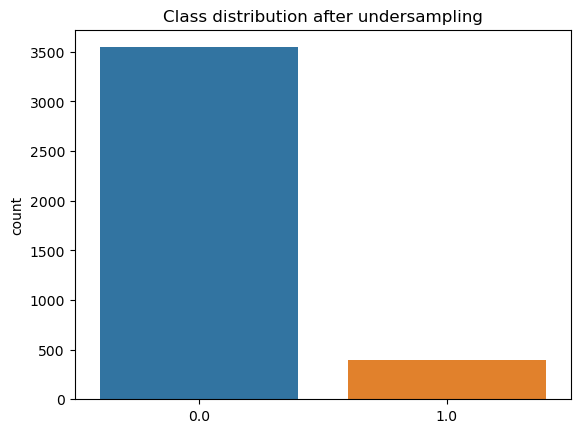

In [35]:
from sklearn.utils import resample

undesampling_proportion = .1

# Separate majority and minority classes
not_fraud_class = X_train[y_train == 0]  # Assuming the majority class label is 0
fraud_class = X_train[y_train == 1]  # Assuming the minority class label is 1

# Undersample the majority class
undersampled_majority = resample(not_fraud_class,
                                replace=False,  # Set to False for undersampling
                                n_samples=int((1/undesampling_proportion-1) * len(fraud_class)),  # Keeping 90% of the minority class
                                random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_X_train = np.concatenate([undersampled_majority, fraud_class])
undersampled_y_train = np.concatenate([np.zeros(len(undersampled_majority)), np.ones(len(fraud_class))])

# Print the class distribution after undersampling
sns.countplot(x=undersampled_y_train).set(title='Class distribution after undersampling');

**SMOTe - Synthetic Minority Over-sampling Technique**, tem o incrível poder de criar dados sintéticos para aumentar a classe minoritária (oversampling). A ideia é simples: observe a figura abaixo; os pontos vermelhos representam a classe minoritária. Podemos criar dados sintéticos a essa base simplesmente adicionando pontos nas linhas que ligam os K pontos mais próximos.

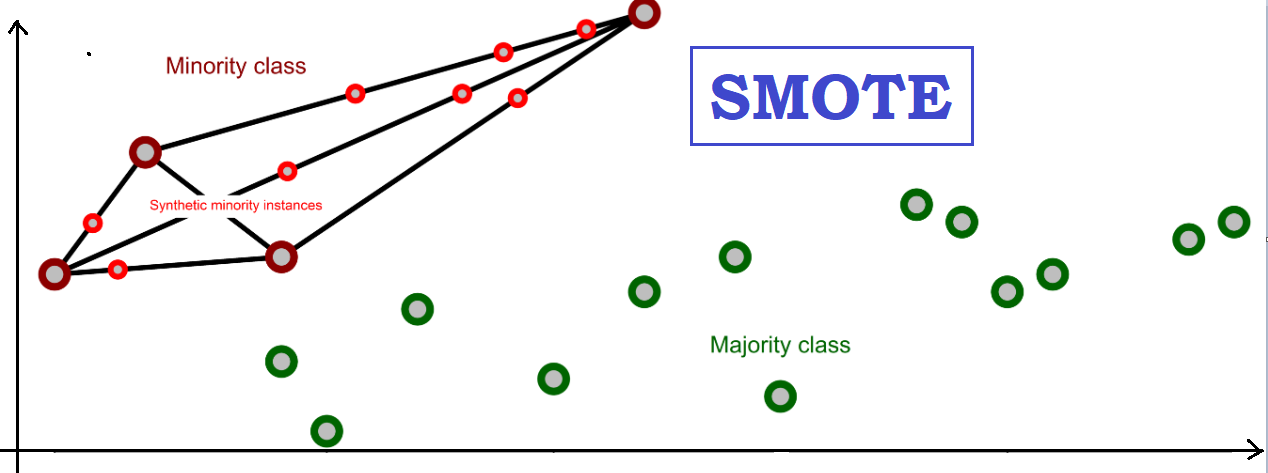

<h3> Training Random Forest and XGBoost </h3>

How this data frame is very umbalanced, the accuracy can't be useful for evaluation of the model. Here, the metrics used are:
<ol>
<li>,<b>Precision</b>: Measures the percentage of hits between observations rated positive</li>
<li><b>Recall</b>: 
Measures the percentage of positive observations that were correctly classified</li>
<li><b>f2</b>: This measurement strikes a balance between sensitivity and accuracy using the harmonic mean of these metrics, givin weight 2 to the Recall
    $$(1+\beta^2)\times\frac{precision\times recall}{\beta^2\times precision+recall}$$</li>
    
<li><b>Kappa</b>: It is a statistical method to assess the level of agreement between two data sets.
    $$kappa=\frac{Acc-Acc_{e}}{1-Acc_{e}},$$ 
where $Acc$ is the accuracy and $Acc_e$ the observed accuracy in a random classifier</li>
</ol>

Um dilema que existe na detecção de fraudes seria o trade-off entre precisão e revocação. Veja a matriz de confusão abaixo:
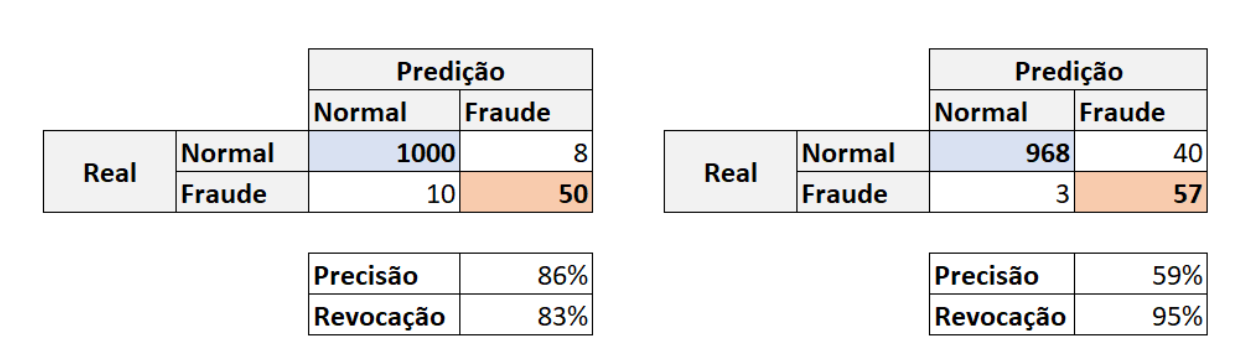


In [37]:
rfc = RandomForestClassifier(n_estimators = 1600,
 min_samples_split = 2,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = 100,
 bootstrap = False)
;

xgb = XGBClassifier(min_child_weight = 5,
 max_depth=12,
 learning_rate= 0.1,
 gamma= 0.2,
 colsample_bytree= 0.7)

In [213]:
def eval_function(y, y_hat_prob, metric='fbeta_score'):
    _, _, tresholds = metrics.roc_curve(y_test, mse)
    scores=[]
    for treshold in tresholds:
        y_hat = (y_hat_prob < treshold).astype(int)
        scores.append([metrics.recall_score(y_pred=y_hat, y_true=y_test),
                     metrics.precision_score(y_pred=y_hat, y_true=y_test),
                     metrics.fbeta_score(y_pred=y_hat, y_true=y_test, beta=2),
                     metrics.cohen_kappa_score(y1=y_hat, y2=y_test)])
    scores = np.array(scores)
    map_metrics = {'recall_score':0, 'precision_score':1, 'fbeta_score':2, 'cohen_kappa_score':3}
    final_tresh = tresholds[scores[:, map_metrics[metric]].argmax()]
    y_hat_best = (y_hat_prob < final_tresh).astype(int)
    cm = metrics.confusion_matrix(y_test,y_hat)
    best_score = scores[scores[:, map_metrics[metric]].argmax(),:]
    recall_score = best_score[0]
    precision_score = best_score[1]
    fbeta_score = best_score[2]
    cohen_kappa_score = best_score[3]
    return {'final_tresh': final_tresh,
            'cm': cm,
            'best_score' : best_score,
            'recall_score' : recall_score,
            'precision_score' : precision_score,
            'fbeta_score' : fbeta_score,
            'cohen_kappa_score' : cohen_kappa_score,
            'scores': scores
           }

<h3> Fit with Random Forest </h3> 
In a simplified way, the random forest algorithm creates several decision trees and combines them to obtain a more accurate and more stable prediction. The Random Forest algorithm has several hyperparameters that need to be configured to optimize performance. We will use the RandomizedSearchCV method to find the best hyperparameters in the model.
<a href="https://medium.com/@ar.ingenious/applying-random-forest-classification-machine-learning-algorithm-from-scratch-with-real-24ff198a1c57">
         <img alt="Qries" src='https://miro.medium.com/max/1170/1*58f1CZ8M4il0OZYg2oRN4w.png'
         width=500" height="300">

In [92]:
rfc.fit(undersampled_X_train,undersampled_y_train)
prediction_rfc = rfc.predict_proba(X_test.values)

To get the confusion matrix with the best metric f2, let's predict the probability that the data points are in a given class and apply a threshold that will find the adjustment we need.

In [99]:
eval_dict = eval_function(y_test, prediction_rfc[:,0], metric='fbeta_score')

print('The recall score is: %.3f' % eval_dict['recall_score'])
print('The precision score is: %.3f' % eval_dict['precision_score'])
print('The f2 score is: %.3f' % eval_dict['fbeta_score'])
print('The Kappa score is: %.3f' % eval_dict['cohen_kappa_score'])

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The recall score is: 0.857
The precision score is: 0.712
The f2 score is: 0.824
The Kappa score is: 0.777


<h3> Trade off Between Precision and Recall </h3>

There is a trade-off between precision and recall as we change the threshold. At a threshold of zero, all values are 'fraud', in which case the precision would be 1 and the recall would be the lowest possible, because in the denominator of this metric the number of false negative would be maximum. The opposite would be true for a threshold of 1: all values rated 'normal' would have recall 1, as it has no false negative, but precision would be as low as possible, as it would have the maximum number of false positive.

We will choose the threshold where the f2-score is maximum.

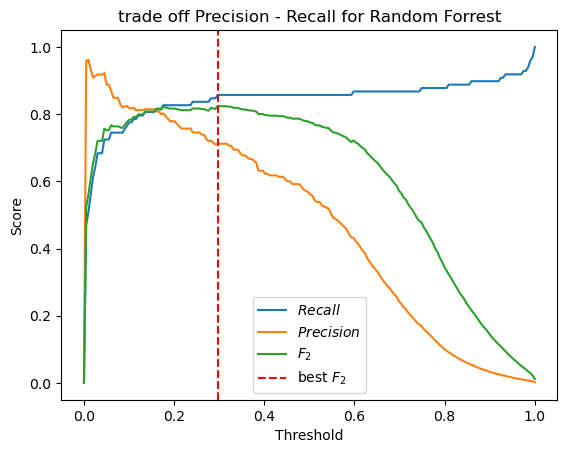

In [106]:
#precision_recall
plt.plot(tresholds, eval_dict['scores'][:, 0], label='$Recall$')
plt.plot(tresholds, eval_dict['scores'][:, 1], label='$Precision$')
plt.plot(tresholds, eval_dict['scores'][:, 2], label='$F_2$')
plt.ylabel('Score')
plt.axvline(x=eval_dict['final_tresh'], color='r', linestyle='--', label='best $F_2$')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Trade off Precision - Recall for Random Forrest')
plt.show()

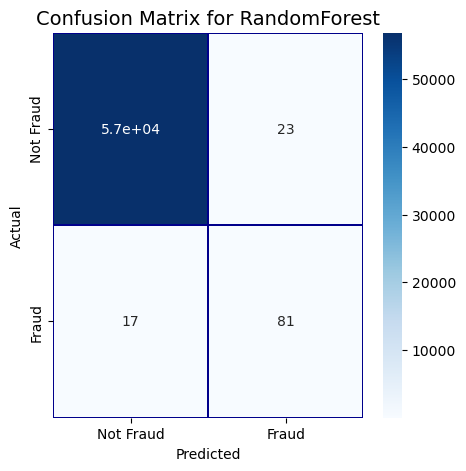

In [116]:
final_tresh = eval_dict['final_tresh']
cm = pd.crosstab(y_test, (prediction_rfc[:,0] < final_tresh).astype(int), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for RandomForest', fontsize=14)
plt.show()

<h3> Feature Importance </h3>
Here we can see which variables influenced the model performance the most.

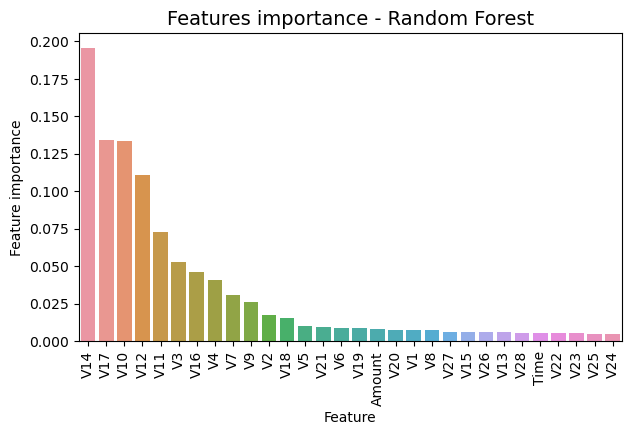

In [79]:
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance - Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

<h2> Fit with XGBoost Classifier </h2>

 The training proceeds iteratively, adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final prediction. It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.
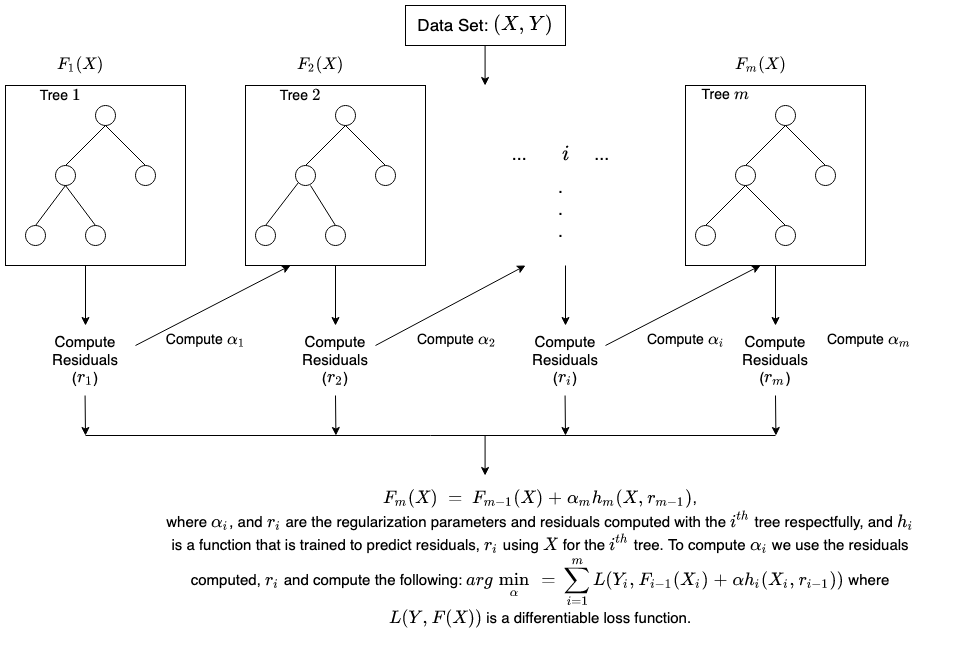

Let's set the parameters for the model and initialize the model, 
analogously to what we did before:

In [107]:
xgb = XGBClassifier(min_child_weight = 5,
 max_depth=12,
 learning_rate= 0.1,
 gamma= 0.2,
 colsample_bytree= 0.7)

xgb.fit(undersampled_X_train, undersampled_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [108]:
prediction_xgb = xgb.predict_proba(X_test.values)

In [109]:
eval_dict = eval_function(y_test, prediction_xgb[:,0], metric='fbeta_score')

print('The recall score is: %.3f' % eval_dict['recall_score'])
print('The precision score is: %.3f' % eval_dict['precision_score'])
print('The f2 score is: %.3f' % eval_dict['fbeta_score'])
print('The Kappa score is: %.3f' % eval_dict['cohen_kappa_score'])

C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The recall score is: 0.847
The precision score is: 0.748
The f2 score is: 0.825
The Kappa score is: 0.794


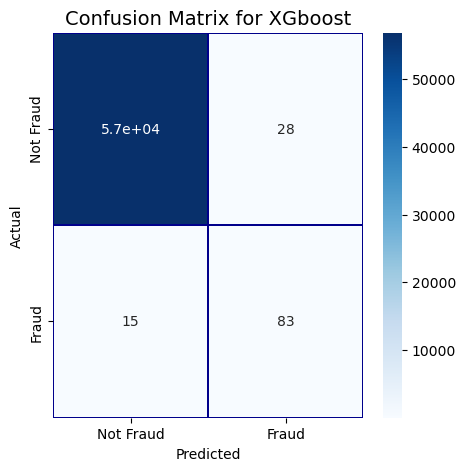

In [117]:
final_tresh = eval_dict['final_tresh']
cm = pd.crosstab(y_test, (prediction_xgb[:,0] < final_tresh).astype(int), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for XGboost', fontsize=14)
plt.show()

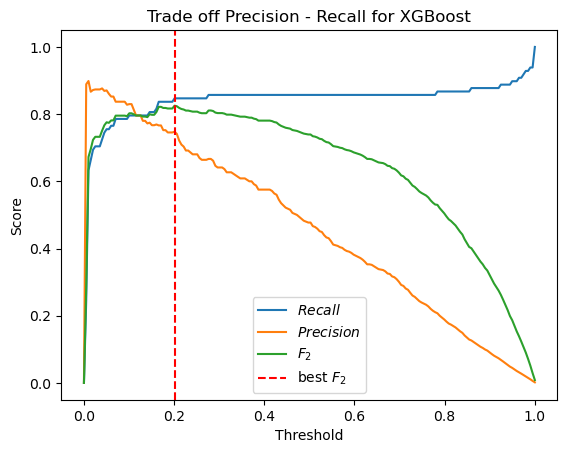

In [118]:
#precision_recall
plt.plot(tresholds, eval_dict['scores'][:, 0], label='$Recall$')
plt.plot(tresholds, eval_dict['scores'][:, 1], label='$Precision$')
plt.plot(tresholds, eval_dict['scores'][:, 2], label='$F_2$')
plt.ylabel('Score')
plt.axvline(x=eval_dict['final_tresh'], color='r', linestyle='--', label='best $F_2$')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Trade off Precision - Recall for XGBoost')
plt.show()

<h3> Usando o Sasgemaker </h3>

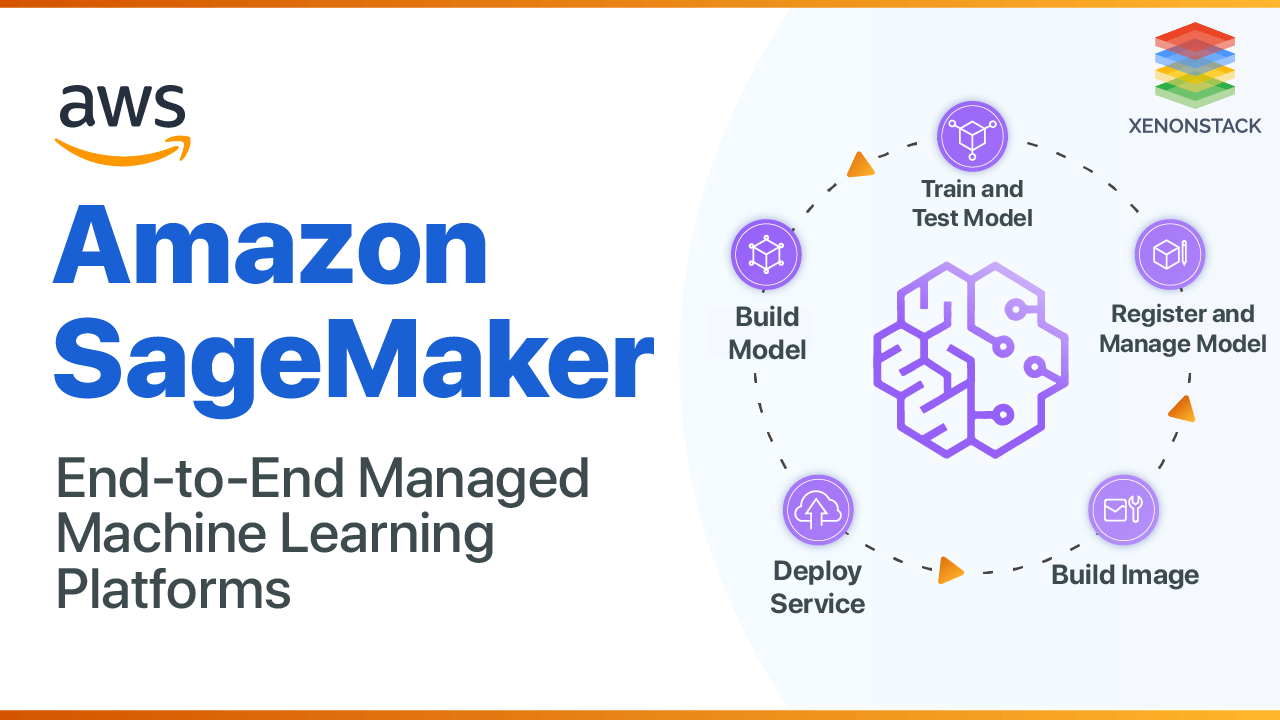

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
import boto3

# Define seu role IAM do SageMaker
role = get_execution_role()

# Configura a sessão do SageMaker
sagemaker_session = sagemaker.Session()

# Especifique o bucket do S3 para armazenar os dados de treinamento e os modelos gerados
bucket_path = 'data-lake/credit-prediction'

# Carregue e prepare seus dados de treinamento
# ...
# Divida os dados em conjuntos de treinamento e validação
# ...
# Faça o pré-processamento, se necessário

# Defina o local de entrada para os dados de treinamento e validação
s3_input_train = TrainingInput(s3_data='s3://{}/train'.format(bucket), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/validation'.format(bucket), content_type='csv')

# Configuração do estimador do XGBoost
container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb_estimator = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/output'.format(bucket),
    sagemaker_session=sagemaker_session
)

xgb_estimator.set_hyperparameters(
    objective='binary:logistic',
    num_round=100
)

# Treinamento do modelo
xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

# Implantação do modelo treinado em um endpoint
xgb_predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

# Exemplo de inferência usando o modelo implantado
data = {'feature1': [1.0, 2.0, 3.0], 'feature2': [4.0, 5.0, 6.0]}
response = xgb_predictor.predict(data)

# Encerre o endpoint quando não for mais necessário
xgb_predictor.delete_endpoint()


<h2> Autoencoders </h2>

Let's use a neural model called autoencoder, in which we ask a neural network to reconstruct the signal passed to it. We will ask the model to reconstruct normal data points and if we pass a fraud data point, it will have a big error which we will use to detect the fraud. In our case. The coded latent layer will have  25 neurons and since our data has 30 variables, this means that the neural network will have to learn an latent representation that condenses 30 dimensions in 25 dimensão going through representation with 100 and 50 neurons (30-100-50-25-50-100 layers).

It's not good use all the normal datapoints of the base, because the model need learn only how to detect frauds, not create a good generalization of normal data points. 
Have little points that represent normal data points is better. 


In [201]:
df = dataframe.sample(frac=1, random_state=42)
X = df.drop(columns = "Class")
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_semisup = X_train[y_train==0]

In [222]:
from numpy.random import seed
from tensorflow.keras import initializers
seed(4)
input_dim = X_train_semisup.shape[1]

Input_layer=Input(shape=(input_dim,))
#encoder
encoding_dim = 300
#init = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=42)
#encoder
encoder=Dense(units=encoding_dim,activation='tanh', use_bias=False, 
              activity_regularizer=regularizers.l1(10e-5))(Input_layer)
encoder=BatchNormalization()(encoder)
encoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
encoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
encoder=Dense(units=int(encoding_dim/4), activation='relu')(encoder)

#decoder
decoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
decoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
decoder=Dense(units=int(encoding_dim), activation='relu')(decoder)
decoder=Dense(units=input_dim,activation='relu')(decoder)


#modelo
autoencoder=Model(inputs=Input_layer,outputs=decoder)
encodermodel=Model(inputs=Input_layer,outputs=encoder)

epochs= 1000
batch_size=2048

#TensorBoard=TensorBoard(log_dir='./logs',histogram_freq=0,write_grads=True,write_images=True)
best_weights_filepath = './best_weights.hdf5'

earlyStopping=EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')

saveBestModel = ModelCheckpoint(best_weights_filepath, monitor='val_loss', 
                                verbose=1, save_best_only=True, mode='auto')
#we use 90% of data for train and 10% for validation
autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

history=autoencoder.fit(X_train_semisup,X_train_semisup,
                    epochs=epochs,batch_size=batch_size,shuffle=False,
                    validation_split=0.3,verbose=1, 
                    callbacks=[saveBestModel,earlyStopping]).history
autoencoder.load_weights(best_weights_filepath)
predictions_AE=autoencoder.predict(X_test)
#mse is the mean squared error between the original data points and the reconstruction data points
mse=np.mean(np.power(X_test - predictions_AE, 2), axis=1)

Epoch 1/400
69/78 [=========================>....] - ETA: 0s - loss: 0.8122 - accuracy: 0.6377
Epoch 1: val_loss improved from inf to 0.88628, saving model to .\best_weights.hdf5
78/78 [==============================] - 1s 8ms/step - loss: 0.7956 - accuracy: 0.6537 - val_loss: 0.8863 - val_accuracy: 0.7788
Epoch 2/400
73/78 [===========================>..] - ETA: 0s - loss: 0.6348 - accuracy: 0.8216
Epoch 2: val_loss improved from 0.88628 to 0.76823, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 6ms/step - loss: 0.6336 - accuracy: 0.8222 - val_loss: 0.7682 - val_accuracy: 0.8230
Epoch 3/400
74/78 [===========================>..] - ETA: 0s - loss: 0.6030 - accuracy: 0.8562
Epoch 3: val_loss improved from 0.76823 to 0.67145, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 6ms/step - loss: 0.6027 - accuracy: 0.8567 - val_loss: 0.6715 - val_accuracy: 0.8561
Epoch 4/400
72/78 [==========================>...] - ETA: 0s - loss:

Epoch 28/400
77/78 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.9321
Epoch 28: val_loss did not improve from 0.56109
78/78 [==============================] - 0s 5ms/step - loss: 0.5610 - accuracy: 0.9319 - val_loss: 0.5626 - val_accuracy: 0.9331
Epoch 29/400
73/78 [===========================>..] - ETA: 0s - loss: 0.5629 - accuracy: 0.9253
Epoch 29: val_loss did not improve from 0.56109
78/78 [==============================] - 0s 5ms/step - loss: 0.5630 - accuracy: 0.9249 - val_loss: 0.5639 - val_accuracy: 0.9178
Epoch 30/400
73/78 [===========================>..] - ETA: 0s - loss: 0.5650 - accuracy: 0.9205
Epoch 30: val_loss improved from 0.56109 to 0.56037, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 5ms/step - loss: 0.5648 - accuracy: 0.9212 - val_loss: 0.5604 - val_accuracy: 0.9334
Epoch 31/400
71/78 [==========================>...] - ETA: 0s - loss: 0.5655 - accuracy: 0.9217
Epoch 31: val_loss improved from 0.56037 to 

Epoch 57/400
74/78 [===========================>..] - ETA: 0s - loss: 0.5557 - accuracy: 0.9383
Epoch 57: val_loss did not improve from 0.55456
78/78 [==============================] - 0s 6ms/step - loss: 0.5559 - accuracy: 0.9382 - val_loss: 0.5550 - val_accuracy: 0.9369
Epoch 58/400
72/78 [==========================>...] - ETA: 0s - loss: 0.5561 - accuracy: 0.9388
Epoch 58: val_loss did not improve from 0.55456
78/78 [==============================] - 0s 5ms/step - loss: 0.5562 - accuracy: 0.9384 - val_loss: 0.5573 - val_accuracy: 0.9307
Epoch 59/400
73/78 [===========================>..] - ETA: 0s - loss: 0.5571 - accuracy: 0.9289
Epoch 59: val_loss improved from 0.55456 to 0.55191, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 5ms/step - loss: 0.5569 - accuracy: 0.9294 - val_loss: 0.5519 - val_accuracy: 0.9361
Epoch 60/400
72/78 [==========================>...] - ETA: 0s - loss: 0.5532 - accuracy: 0.9360
Epoch 60: val_loss improved from 0.55191 to 

Epoch 86/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5487 - accuracy: 0.9453
Epoch 86: val_loss did not improve from 0.54915
78/78 [==============================] - 0s 5ms/step - loss: 0.5510 - accuracy: 0.9453 - val_loss: 0.5492 - val_accuracy: 0.9424
Epoch 87/400
66/78 [========================>.....] - ETA: 0s - loss: 0.5480 - accuracy: 0.9461
Epoch 87: val_loss improved from 0.54915 to 0.54878, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 5ms/step - loss: 0.5505 - accuracy: 0.9465 - val_loss: 0.5488 - val_accuracy: 0.9482
Epoch 88/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5488 - accuracy: 0.9450
Epoch 88: val_loss did not improve from 0.54878
78/78 [==============================] - 0s 5ms/step - loss: 0.5513 - accuracy: 0.9441 - val_loss: 0.5511 - val_accuracy: 0.9314
Epoch 89/400
74/78 [===========================>..] - ETA: 0s - loss: 0.5523 - accuracy: 0.9375
Epoch 89: val_loss improved from 0.54878 to 

72/78 [==========================>...] - ETA: 0s - loss: 0.5534 - accuracy: 0.9357
Epoch 115: val_loss did not improve from 0.54804
78/78 [==============================] - 0s 6ms/step - loss: 0.5531 - accuracy: 0.9362 - val_loss: 0.5485 - val_accuracy: 0.9423
Epoch 116/400
78/78 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.9444
Epoch 116: val_loss did not improve from 0.54804
78/78 [==============================] - 0s 5ms/step - loss: 0.5512 - accuracy: 0.9444 - val_loss: 0.5522 - val_accuracy: 0.9368
Epoch 117/400
71/78 [==========================>...] - ETA: 0s - loss: 0.5556 - accuracy: 0.9339
Epoch 117: val_loss did not improve from 0.54804
78/78 [==============================] - 0s 5ms/step - loss: 0.5546 - accuracy: 0.9342 - val_loss: 0.5509 - val_accuracy: 0.9356
Epoch 118/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5513 - accuracy: 0.9367
Epoch 118: val_loss did not improve from 0.54804
78/78 [==============================] - 0s

78/78 [==============================] - 0s 5ms/step - loss: 0.5511 - accuracy: 0.9432 - val_loss: 0.5476 - val_accuracy: 0.9488
Epoch 145/400
72/78 [==========================>...] - ETA: 0s - loss: 0.5501 - accuracy: 0.9462
Epoch 145: val_loss improved from 0.54746 to 0.54742, saving model to .\best_weights.hdf5
78/78 [==============================] - 0s 5ms/step - loss: 0.5500 - accuracy: 0.9465 - val_loss: 0.5474 - val_accuracy: 0.9552
Epoch 146/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5469 - accuracy: 0.9505
Epoch 146: val_loss did not improve from 0.54742
78/78 [==============================] - 0s 5ms/step - loss: 0.5492 - accuracy: 0.9509 - val_loss: 0.5477 - val_accuracy: 0.9516
Epoch 147/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5485 - accuracy: 0.9454
Epoch 147: val_loss did not improve from 0.54742
78/78 [==============================] - 0s 5ms/step - loss: 0.5510 - accuracy: 0.9439 - val_loss: 0.5517 - val_accuracy: 0.9301
Epoch

Epoch 174/400
71/78 [==========================>...] - ETA: 0s - loss: 0.5526 - accuracy: 0.9392
Epoch 174: val_loss did not improve from 0.54694
78/78 [==============================] - 0s 5ms/step - loss: 0.5518 - accuracy: 0.9398 - val_loss: 0.5488 - val_accuracy: 0.9477
Epoch 175/400
68/78 [=========================>....] - ETA: 0s - loss: 0.5491 - accuracy: 0.9415
Epoch 175: val_loss did not improve from 0.54694
78/78 [==============================] - 0s 5ms/step - loss: 0.5512 - accuracy: 0.9431 - val_loss: 0.5472 - val_accuracy: 0.9564
Epoch 176/400
70/78 [=========================>....] - ETA: 0s - loss: 0.5503 - accuracy: 0.9503
Epoch 176: val_loss did not improve from 0.54694
78/78 [==============================] - 0s 5ms/step - loss: 0.5503 - accuracy: 0.9489 - val_loss: 0.5523 - val_accuracy: 0.9387
Epoch 177/400
69/78 [=========================>....] - ETA: 0s - loss: 0.5508 - accuracy: 0.9417
Epoch 177: val_loss did not improve from 0.54694
78/78 [======================

Text(0.5, 1.0, 'loss in train and validation split')

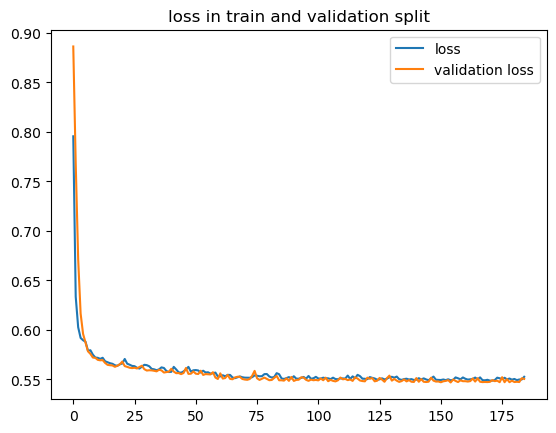

In [223]:
#plotting the history of the model\qz
plt.figure()
plt.plot(history['loss'],label='loss')
plt.legend()
plt.plot(history['val_loss'],label='validation loss')
plt.legend()
plt.title('loss in train and validation split')

Text(0.5, 1.0, 'Reconstruction error')

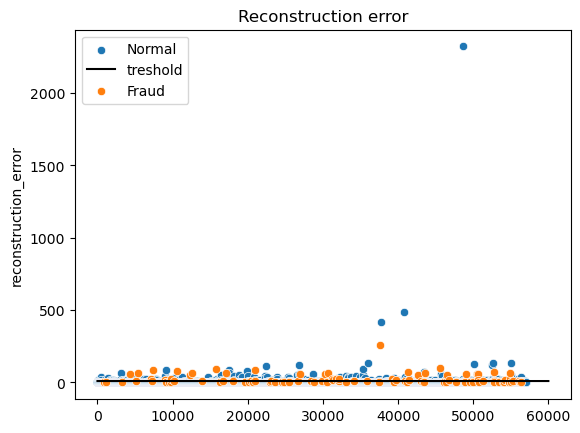

In [224]:
y_test=np.array(y_test)
mse=np.array(mse)
error_df=pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})
t0 = error_df.loc[error_df['true_class'] == 0]
t1 = error_df.loc[error_df['true_class'] == 1]
t2=final_tresh*np.ones((60000,), dtype=int)
sns.scatterplot(data = t0['reconstruction_error'] ,label="Normal")
sns.lineplot(data=t2, color='black', label='treshold')
sns.scatterplot(data = t1['reconstruction_error'],label="Fraud").set_title('Reconstruction error')

In [225]:
eval_dict = eval_function(y_test, 1/mse, metric='fbeta_score')

print('The recall score is: %.3f' % eval_dict['recall_score'])
print('The precision score is: %.3f' % eval_dict['precision_score'])
print('The f2 score is: %.3f' % eval_dict['fbeta_score'])
print('The Kappa score is: %.3f' % eval_dict['cohen_kappa_score'])

The recall score is: 0.500
The precision score is: 0.183
The f2 score is: 0.371
The Kappa score is: 0.266


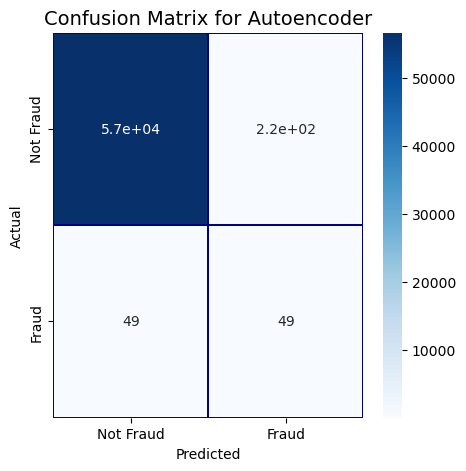

In [221]:
cm = pd.crosstab(y_test, y_hat_AE, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Autoencoder', fontsize=14)
plt.show()